# Analysis fastReach 

## general prep

In [1]:

# load packages
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
# %load_ext rpy2.ipython # currently not needed
import glob

from wordcloud import WordCloud, STOPWORDS
#from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pymer4 as pymer4
   


In [2]:
# set path^
# --> clean up
d = "C://Users/terfu/Desktop/2021-fastReach/analyses/Leonie_tests/" # for test data

p = "C://Users/terfu/Desktop/2021-fastReach/data/study/" #repository for data access
pp = "C://Users/terfu/Desktop/2021-fastReach/data/study/" #repository for output

## load functions

In [7]:
from LT_plotting_funcs import *

# 1. Intentional Binding


### load data

In [4]:
# load data
behavior = pd.read_csv( p + 'PI_results_test_data.csv')

# set data types
behavior[['ed','rt']] = behavior[['ed','rt']].apply(pd.to_numeric, axis=1)

behavior['rd'] = behavior['rd'].astype("string")  # needs to be string before category for R conversion

behavior[['rd','condition']] = behavior[['rd','condition']].astype("category")


### plot only one condition

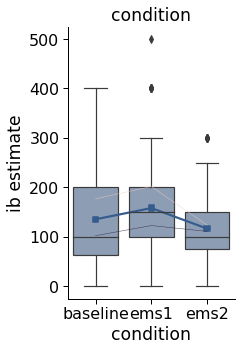

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [5]:
# with only stimulation condition
behavior_means = behavior.groupby(['id','condition'],as_index=False)['ed'].mean()

palette = ['#365c8d','#E5E4E2','#899499','#4ac16d', '#277f8e','#440154'] 
cats= ['baseline','random','EEG'] 
ylabel = 'ib estimate'
xlabel = 'condition'
title = 'condition'
data = behavior
data_means = behavior_means
y = "ed"
x = "condition"
hue = "id"


plot_3_cats_pID(data, x, y, hue, ylabel, xlabel,cats,palette,data_means,title)

### plot both conditions

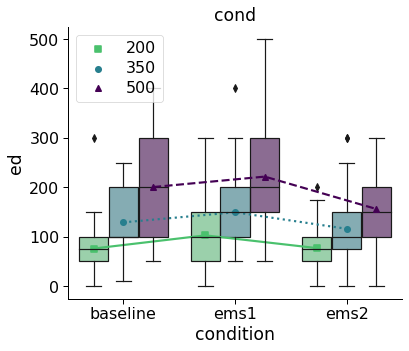

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [8]:
# with stimulation condition + time condition+ rd as y
behavior_means = behavior.groupby(['id','condition','rd'],as_index=False)['ed'].mean()


palette = ['#365c8d','#E5E4E2','#899499','#4ac16d', '#277f8e','#440154'] 
cats= ['baseline','ems1','ems2'] 
ylabel = 'ed'
xlabel = 'condition'
title = 'cond'
data = behavior
data_means = behavior_means
y = "ed"
x = "condition"
hue = "id"
hue2 = 'rd'


plot_3_cats_hue(data, x, y, hue, ylabel, xlabel,cats,palette,data_means,hue2,title)

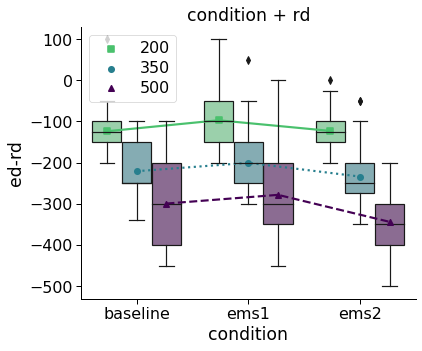

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [19]:
# with stimulation condition + time condition+ rd as y

behavior[['rd']] = behavior[['rd']].apply(pd.to_numeric, axis=1)
behavior["diff"]= behavior["ed"]-behavior["rd"]
behavior[['rd']] = behavior[['rd']].astype("category")


behavior_means = behavior.groupby(['id','condition','rd'],as_index=False)['diff'].mean()

palette = ['#365c8d','#E5E4E2','#899499','#4ac16d', '#277f8e','#440154'] 
cats= ['baseline','ems1','ems2'] 
ylabel = 'ed-rd'
xlabel = 'condition'
title = 'condition + rd'
data = behavior
data_means = behavior_means
y = "diff"
x = "condition"
hue = "id"
hue2 = 'rd'


plot_3_cats_hue(data, x, y, hue, ylabel, xlabel,cats,palette,data_means,hue2,title)

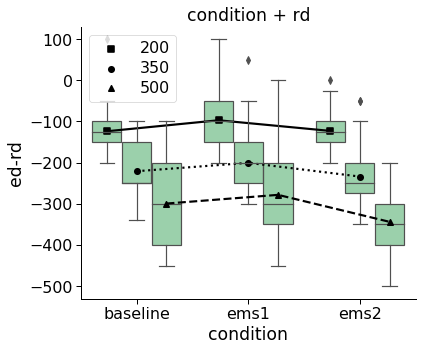

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [43]:
# runs plot but needs post processing in affinty desiger
cats_0 = data[data[x]==cats[0]]
cats_1 = data[data[x]==cats[1]]
cats_2 = data[data[x]==cats[2]]

pairs = [(cats[0], cats[1],cats[1])]


with sns.plotting_context('paper', font_scale = 1.8):

    ### Create new plot
    fig, ax = plt.subplots(1, 1, figsize=(6,5))
    fig.patch.set_alpha(1)

    sns.despine() #bottom=True, left=True

        # show boxplots
    ax = sns.boxplot(data = data,x = x, y = y, hue = hue2,  palette= [palette[3],palette[3],palette[3]])
    for patch in ax.patches: # adapt alpha
            r, g, b, a = patch.get_facecolor()
            patch.set_facecolor((r, g, b, .6))

        # show line connecting menas
    ax = sns.pointplot(
        data = data,x = x, y = y, dodge=.8 - .8 / 3,
        markers=['s','o','^'],linestyles = ['solid','dotted','dashed'],hue = hue2, size = 6, ci =None,palette= ['black','black','black'], labels = True)
    

    handles, labels = ax.get_legend_handles_labels()  
    
    plt.legend(handles[3:6],labels[3:6],frameon=True,loc = 'upper left',labelspacing =0.3)
    
    # label_plot_for_subcats(ax)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    
    plt.show()
fig.savefig('results/'+title + '_' + ylabel + '_' + xlabel + '.svg', format='eps', transparent=True, bbox_inches='tight', dpi=300)

histogramm rt

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


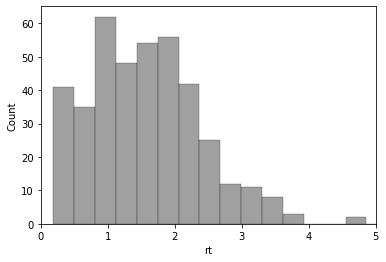

In [10]:

fig, ax = plt.subplots()
hist = sns.histplot(behavior, x = 'rt',color= 'grey',ax =ax)
ax.set_xlim(0,5) # remove outliers for visualization

hist.figure.savefig(d+'results/hist_rt.png', format='png', transparent=False, bbox_inches='tight', dpi=300)
hist.figure.savefig(d+'results/hist_rt.eps', format='eps', transparent=True, bbox_inches='tight', dpi=300)

### linear mixed model

#### prep
- witched from rpy2 to pymer4, because it is less annoying with importing / exporting from python to R
- not sure if of this is still necessary, but since pymer4 is based on rpy2, this might be the case

In [11]:
packnames = ('lme4', 'lmerTest', 'emmeans', 'geepack', 'sjPlot')
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
utils = importr("utils")
utils.chooseCRANmirror(ind=1)

<rpy2.rinterface_lib.sexp.NULLType object at 0x000002489E18D980> [RTYPES.NILSXP]

In [12]:
packnames = ('lme4', 'lmerTest', 'emmeans', 'geepack', 'sjPlot')
from rpy2.robjects.vectors import StrVector
utils.install_packages(StrVector(packnames))
from pymer4.models import Lmer

R[write to console]: Installiere Pakete nach 'C:/Users/terfu/AppData/Local/R/win-library/4.2'
(da 'lib' nicht spezifiziert)

R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.2/lme4_1.1-34.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 4529677 bytes (4.3 MB)

R[write to console]: downloaded 4.3 MB


R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.2/lmerTest_3.1-3.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 530095 bytes (517 KB)

R[write to console]: downloaded 517 KB


R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.2/emmeans_1.8.7.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 2173125 bytes (2.1 MB)

R[write to console]: downloaded 2.1 MB


R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.2/geepack_1.3.9.zip'

R[write to console]

Paket 'lme4' erfolgreich ausgepackt und MD5 Summen abgeglichen
Paket 'lmerTest' erfolgreich ausgepackt und MD5 Summen abgeglichen
Paket 'emmeans' erfolgreich ausgepackt und MD5 Summen abgeglichen
Paket 'geepack' erfolgreich ausgepackt und MD5 Summen abgeglichen
Paket 'sjPlot' erfolgreich ausgepackt und MD5 Summen abgeglichen




Exception ignored from cffi callback <function _consolewrite_ex at 0x000002489E13E9E0>:
Traceback (most recent call last):
  File "c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 138, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe4 in position 25: invalid continuation byte


Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: ed~condition*rd+(1|id)

Family: gaussian	 Inference: parametric

Number of observations: 404	 Groups: {'id': 2.0}

Log-likelihood: -2327.056 	 AIC: 4676.112

Random effects:

                 Name       Var     Std
id        (Intercept)   739.225  27.189
Residual               5802.028  76.171

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),79.074,35.304,122.844,22.332,3.369,3.541,0.032,*
condition1,26.667,-4.807,58.140,16.058,402.000,1.661,0.098,.
condition2,0.889,-30.585,32.363,16.058,402.000,0.055,0.956,
rd1,53.000,21.526,84.474,16.058,402.000,3.300,0.001,**
rd2,124.444,92.971,155.918,16.058,402.000,7.750,0.000,***
condition1:rd1,-6.885,-51.522,37.752,22.774,402.000,-0.302,0.763,
condition2:rd1,-13.889,-58.399,30.622,22.710,402.000,-0.612,0.541,
condition1:rd2,-5.556,-50.066,38.955,22.710,402.000,-0.245,0.807,
condition2:rd2,-45.333,-89.844,-0.823,22.710,402.000,-1.996,0.047,*


<AxesSubplot:xlabel='Estimate'>

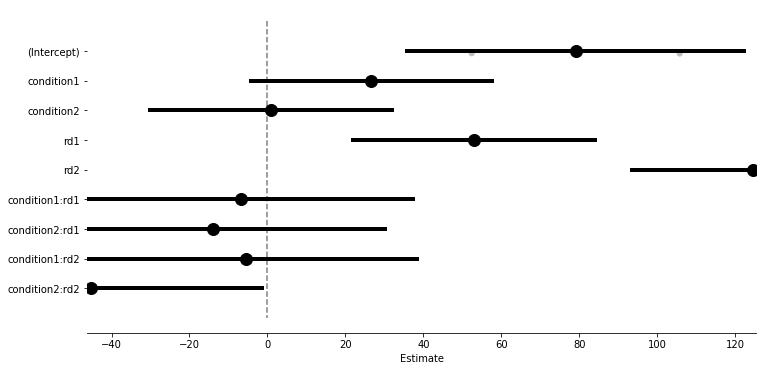

In [13]:
# does not run with one pID (RRuntimeError: Error: grouping factors must have > 1 sampled level)

full_model = Lmer('ed ~ condition * rd + (1|id)', data = behavior)
display(full_model.fit(REML = False,factors={"condition": ["baseline", "ems1", "ems2"], "rd": ["200", "350", "500"]}))
full_model.plot_summary()

#### define null models

In [14]:
# null without interaction
null_model_int = Lmer('ed ~ condition + rd + (1|id)', data = behavior)
null_model_int.fit(REML = False, summarize=False)

# null model without stimulation condition 
null_model_stim = Lmer('ed ~ rd + (1|id)', data = behavior)
null_model_stim.fit(REML = False, summarize=False)

# null model without temp condition 
null_model_temp = Lmer('ed ~ condition + (1|id)', data = behavior)
null_model_temp.fit(REML = False, summarize=False)


c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning: Error while trying to convert the column "rd". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '
c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning: Error while trying to convert the column "rd". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '
c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning: Error while trying to convert the column "rd". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are

#### liklyhood ratio tests
To DO: discussed before but: when we have a full model with interaction, 
what do we use as null models for liklyhood ration test? When we leave the interaction out compleatly,
 we can not use the ß estimates from the full model (Ithink)


interaction

In [15]:
pymer4.stats.lrt([null_model_int,full_model])


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,ed~condition+rd+(1|id),7,4673.266390,4701.276294,-2329.633195,4659.266390,,,,
1,ed~condition*rd+(1|id),11,4676.112313,4720.127877,-2327.056157,4654.112313,5.154077,4.0,0.27185,


stimulation condition

In [16]:
pymer4.stats.lrt([null_model_stim,full_model])

,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,ed~rd+(1|id),5,4688.461440,4708.468515,-2339.230720,4678.461440,,,,
1,ed~condition*rd+(1|id),11,4676.112313,4720.127877,-2327.056157,4654.112313,24.349127,6.0,0.00045,***


temp condition

In [17]:
pymer4.stats.lrt([null_model_temp,full_model])

,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,ed~condition+(1|id),5,4784.594290,4804.601365,-2387.297145,4774.594290,,,,
1,ed~condition*rd+(1|id),11,4676.112313,4720.127877,-2327.056157,4654.112313,120.481977,6.0,0.0,***


#### post hoc test

TODO check wether this post_hoc test is correct

In [18]:
# post hoc test stimulation condition
marginal_estimates, comparisons = full_model.post_hoc(
    marginal_vars="condition",p_adjust = "bonf")

print(comparisons)


P-values adjusted by bonf method for 3 comparisons
          Contrast  Estimate  2.5_ci  97.5_ci     SE     DF  T-stat  P-val  \
1  baseline - ems1   -22.520 -44.851   -0.189  9.289  402.0  -2.424  0.047   
2  baseline - ems2    18.852  -3.437   41.140  9.271  402.0   2.033  0.128   
3      ems1 - ems2    41.372  19.041   63.702  9.289  402.0   4.454  0.000   

   Sig  
1    *  
2       
3  ***  


In [19]:
# post hoc test stimulation condition
marginal_estimates, comparisons = full_model.post_hoc(
    marginal_vars="rd",p_adjust = "bonf")

print(comparisons)

P-values adjusted by bonf method for 3 comparisons
        Contrast  Estimate   2.5_ci  97.5_ci     SE     DF  T-stat  P-val  Sig
1  rd200 - rd350   -46.075  -68.406  -23.745  9.289  402.0  -4.960    0.0  ***
2  rd200 - rd500  -107.481 -129.770  -85.193  9.271  402.0 -11.593    0.0  ***
3  rd350 - rd500   -61.406  -83.737  -39.075  9.289  402.0  -6.611    0.0  ***


# 2. EEG Data

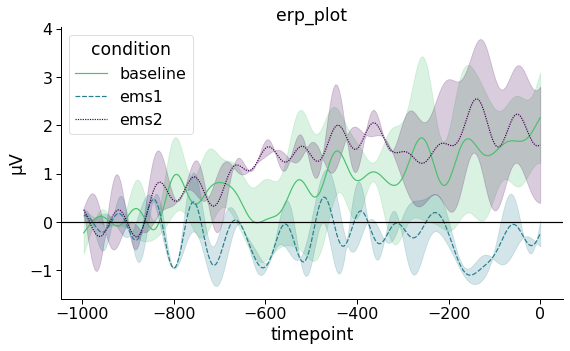

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [8]:
eeg_data = pd.read_csv( p +'PI_results_test_data.csv')

data = eeg_data
id_vars = ['id','condition','tr_nr','rd','ed']
id_vars_2 = ['id','condition']
delete_vars = 'rt' # metrics that are not erp
sample_rate = 250
window_start = -1000 
hue = 'condition'
palette = ['#365c8d','#E5E4E2','#899499','#4ac16d', '#277f8e','#440154'] 
title = 'erp_plot'
data_2 = eeg_data.groupby(['id','condition'],as_index=False)[eeg_data.columns[eeg_data.columns.str.contains(pat = 'erp')]].mean()

#plotting based on single trials ( e.g. when only plotting one person)
#plot_erp_timeline(data,id_vars,delete_vars,sample_rate,window_start,hue,palette,title)

#plotting based on mean values for pID
plot_erp_timeline_2(data_2, id_vars_2,sample_rate,window_start,hue,palette,title)



 

# 2. Questionaire results
- items per block "„Während der Aufgabe hat es sich angefühlt, als hätte ich die Kontrolle über die Bewegungen.“
- input pid|first_block|control_random|control_EEG|expectation_fit|embodiment
- paired t-testsf
- box plots
- SD,M,effect size

@ Lukas? Significance test mit 5 values ist wirklich etwas shady, oder?

In [102]:
#laod fake data
questionaire= pd.read_csv('fake_data/subjective_fastReach.csv', sep = ';')

In [45]:
questionaire= pd.read_excel(pp + 'questionaire _test_data.xlsx') #read from repository 'remove test_data 


c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


### plot control

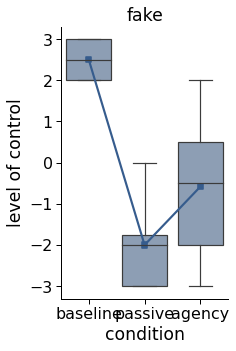

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [46]:
questionaire_long = questionaire.melt(id_vars= ['pID'],value_vars=['baseline','passive','agency'])

palette = ['#365c8d','#E5E4E2','#899499','#4ac16d', '#277f8e','#440154'] 
cats= ['item_baseline', 'item_passive', 'item_agency']
ylabel = 'level of control'
xlabel = 'condition'
title = 'fake'
data = questionaire_long
y = 'value'
x = 'variable'
hue = 'pID'

plot_3_cats(data, x, y, ylabel, xlabel,cats,palette,title)

#cohend(data,x,y, cats)

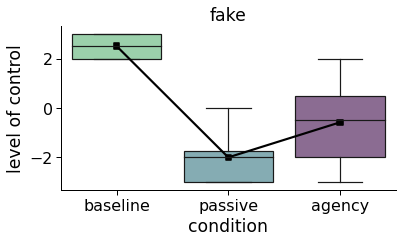

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [57]:
#test-- > to be integrated into plot_3_cats?

cats_0 = data[data[x]==cats[0]]
cats_1 = data[data[x]==cats[1]]
cats_2 = data[data[x]==cats[2]]

pairs = [(cats[0], cats[1],cats[1])]

with sns.plotting_context('paper', font_scale = 1.8):

        ### Create new plot
        fig, ax = plt.subplots(1, 1, figsize=(6,3))
        fig.patch.set_alpha(1)

        sns.despine() #bottom=True, left=True
         # show boxplots
        ax = sns.boxplot(data = data, x = x, y = y,  palette= palette[3:6])
        for patch in ax.patches: # adapt alpha
             r, g, b, a = patch.get_facecolor()
             patch.set_facecolor((r, g, b, .6))

        # show lines connecting pid means observations    
        #sns.lineplot(data = data, x = x, y = y, hue = hue,
        #            legend = False, linewidth = 0.5, linestyle = '-',ci =None,color = 'grey', alpha=0.8)
        

            
        # show line connecting means
        sns.pointplot(
            data = data,x = x, y = y,
            markers="s",linewidth = 1, size = 6, ci =None,color = 'black',legend = False)

        #sns.scatterplot(data = data,x = x, y = y, markers="^",color = 'black')


        
        # Label and show
        # label_plot_for_subcats(ax)
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)

      

        plt.show()
        fig.savefig('results/'+title + '_' + ylabel + '_' + xlabel + '.svg', format='eps', transparent=True, bbox_inches='tight', dpi=300)

### numbers control

In [38]:
questionaire_long.groupby('variable')['value'].agg(["mean", "std"])


,mean,std
variable,,
item_agency,-0.583333,1.880925
item_baseline,2.500000,0.522233
item_passive,-2.000000,0.953463


### count expectation

In [39]:
questionaire['expectation_fit'].value_counts()

KeyError: 'expectation_fit'

### count embodiment

In [108]:
questionaire['embodiment'].value_counts()

nein    11
ja      11
Name: embodiment, dtype: int64

# 3. Content Analysis
--> not yet adapted to new file format
- built to world clouds for each block
- define stopwords
- maybe check sentiment analysis -> pareid t-test?
-TODO: try word cloud german


In [70]:
interview_baseline = questionaire['text_baseline'].dropna().to_json()

interview_passive = questionaire['text_passive'].dropna().to_json()

interview_agency = questionaire['text_agency'].dropna().to_json()

stopwords = STOPWORDS # extend by domaine specific words if necessary



In [68]:
print(interview_baseline)

{"0":"I chose to press the screen; I was using my free will","1":"Ich hatte kein Strom Gef\u00fchl; H\u00e4tte ich nicht gedr\u00fcckt, w\u00e4re der Ton nicht gekommen.","2":"Es war  nicht manipuliert; ich habe ausgew\u00e4hlt wann ich tippe; es war mein inneres Gef\u00fchl"}


In [71]:
wc_formate = WordCloud(background_color='black', max_words=500, width=3000,
                    height=1500, stopwords=stopwords, min_font_size=2,
                    contour_width=3, contour_color='white')

wc_formate.generate(interview_baseline)
wc_formate.to_file((d+"results/wordcloud_baseline.png"))

wc_formate.generate(interview_passive)
wc_formate.to_file((d+"results/wordcloud_passive.png"))

wc_formate.generate(interview_passive)
wc_formate.to_file((d+"results/wordcloud_agency.png"))


# 4. Sentiment Analysis

In [72]:
# for whole text

analyzer=SentimentIntensityAnalyzer()  

print(analyzer.polarity_scores(interview_baseline))
print(analyzer.polarity_scores(interview_passive))
print(analyzer.polarity_scores(interview_agency))



{'neg': 0.166, 'neu': 0.764, 'pos': 0.07, 'compound': -0.6705}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.323, 'neu': 0.677, 'pos': 0.0, 'compound': -0.9815}
